# Prep

In [2]:
import tensorflow as tf
import os
import numpy as np

image_dimensions = (512, 512)
dataset_percent = 50
batch_size = 16

include_other_class = True

if include_other_class is True:
    model_filepath = f'./models/142_class/fastener_net_{str(image_dimensions[0])}_fine_tuned.keras'
else:
    model_filepath = f'./models/142_class/fastener_net_{str(image_dimensions[0])}_NO_OTHER_fine_tuned_new.keras'

training_presets_subfolder_name = f'142_class/{str(image_dimensions[0])}'
model_results_folder = f'./model_results/{str(image_dimensions[0])}_{str(dataset_percent)}_142_class'
model_results_filepath = f'{model_results_folder}/results.md'


print(training_presets_subfolder_name)

142_class/512


In [2]:
%reset -f

# Load Data

In [3]:
import pickle
from sklearn.preprocessing import LabelEncoder

if include_other_class is True:
  dataset_filepath = f"./datasets/{training_presets_subfolder_name}/full_dataset.pkl"
  encoder_filepath = f"./datasets/{training_presets_subfolder_name}/encoder.pkl"
else:
  dataset_filepath = f"./datasets/{training_presets_subfolder_name}/full_dataset_NO_OTHER.pkl"
  encoder_filepath = f"./datasets/{training_presets_subfolder_name}/encoder_NO_OTHER.pkl"

with open(dataset_filepath, "rb") as file:
  print('Loading dataset...')
  dataset = pickle.load(file)
  print('Done!')
  
dataset = dataset[:int(dataset_percent/100 * len(dataset))]
test_set_start_index = int(0.85 * len(dataset))
test_set = dataset[test_set_start_index:]

with open(encoder_filepath, "rb") as file:
  print('Loading encoder...')
  label_encoder = pickle.load(file)
  print('Done!')

Loading dataset...
Done!
Loading encoder...
Done!


In [4]:
test_set_encoded = [(image, label_encoder.transform([label])[0]) for image, label in test_set]

(test_images, test_labels) = zip(*test_set_encoded)

# del test_set_encoded

test_images = np.array(test_images)
test_labels = np.array([int(label) for label in test_labels])

print(len(test_labels))

636


In [5]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

print(len(test_dataset))
# del test_images, test_labels

2024-06-14 03:16:34.304034: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-14 03:16:34.358625: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-14 03:16:34.370201: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

40


# Inference

### Initial Results

In [6]:
from tensorflow import keras

test_model = keras.models.load_model(model_filepath)
evaluation_results = test_model.evaluate(test_dataset)
print(f"Test accuracy: {evaluation_results[1]:.3f}")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 428 variables whereas the saved optimizer has 38 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
2024-06-14 03:16:38.848102: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 500170752 exceeds 10% of free system memory.
2024-06-14 03:16:42.306891: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
2024-06-14 03:16:42.980876: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 919.01MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - accuracy: 0.6847 - loss: 1.3960
Test accuracy: 0.701


### Additional Metrics

##### Meta-Category Analysis

In [22]:
import json

classes = set()

with open('./datasets/categories_inverse.json', 'rb') as file:
  classes = json.load(file)

print(len(classes))

142


In [23]:
pred = test_model.predict(test_dataset)
pred_labels = np.argmax(pred, axis=1)

test_labels = np.concatenate([y for x, y in test_dataset], axis=0)

test_labels = label_encoder.inverse_transform(test_labels)
pred_labels = label_encoder.inverse_transform(pred_labels)

160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


2024-06-13 12:47:23.760929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [24]:
print(test_labels)
print(pred_labels)

count = 0
count_between = 0
count_inside = 0
count_miss_other = 0

per_class_error_count = {class_name: 0 for class_name in classes.keys()}
per_meta_class_error_count = {str(class_name): 0 for class_name in list(set(classes.values()))}

for i in range(0, len(test_labels)):
  if test_labels[i] != pred_labels[i]:
    per_class_error_count[test_labels[i]] += 1
    per_meta_class_error_count[str(classes[test_labels[i]])] += 1
    # print(f"Real label: {test_labels[i]}, Predicted label: {pred_labels[i]}")
    if(classes[pred_labels[i]] != classes[test_labels[i]]):
      # print("Missed between categories")
      count_between += 1
    else:
      # print("Missed inside categories")
      count_inside += 1
    count += 1
  if test_labels[i] != pred_labels[i] and (classes[pred_labels[i]] == 0 or classes[test_labels[i]] == 0):
    count_miss_other += 1
    
print(f"Errors between classes: {count_between}, {count_between/count*100:.2f}% of total errors")
print(f"Errors inside classes: {count_inside}, {count_inside/count*100:.2f}% of total errors")
print(f"Errors including class 'other': {count_miss_other}, {count_miss_other/count*100:.2f}% of total errors")
print(f"Total errors: {count} out of {len(test_labels)}")

print(per_class_error_count)
print(per_meta_class_error_count)

with open(f"{model_results_filepath}", "w") as file:
  file.write(f"# Model: {model_filepath}\n\n")
  file.write(f"### Test Results\n")
  file.write(f"Test accuracy: {evaluation_results[1]:.3f}\n")
  file.write(f"Errors between classes: {count_between}, {count_between/count*100:.2f}% of total errors\n")
  file.write(f"Errors inside classes: {count_inside}, {count_inside/count*100:.2f}% of total errors\n")
  file.write(f"Errors including class 'other': {count_miss_other}, {count_miss_other/count*100:.2f}% of total errors\n")
  file.write(f"Total errors: {count} out of {len(test_labels)}\n\n")
  file.write(f'{per_class_error_count}\n')
  file.write(f'{per_meta_class_error_count}\n')

['452' '142' '352' ... '264' '125' '189']
['452' '142' '352' ... '264' '125' '189']
Errors between classes: 115, 15.56% of total errors
Errors inside classes: 624, 84.44% of total errors
Errors including class 'other': 31, 4.19% of total errors
Total errors: 739 out of 2546
{'495': 14, '212': 3, '260': 6, '3106': 0, '290': 1, '147': 3, '196': 0, '491': 0, '207': 6, '125': 9, '329': 5, '220': 11, '215': 8, '245': 7, '348': 0, '178': 0, '223': 1, '411': 3, '300': 9, '168': 1, '233': 5, '626': 1, '441': 0, '195': 17, '242': 29, '119': 14, '324': 4, '469': 6, '155': 25, '370': 0, '315': 0, '249': 1, '333': 0, '335': 2, '3221': 5, '139': 0, '232': 1, '115': 2, '183': 7, '106': 2, '667': 1, '209': 8, '452': 0, '666': 2, '352': 11, '486': 1, '246': 2, '298': 2, '357': 12, '294': 2, '465': 9, '368': 8, '380': 5, '547': 6, '201': 36, '268': 3, '108': 4, '665': 14, '314': 0, '189': 14, '358': 2, '591': 2, '103': 4, '269': 4, '259': 0, '369': 3, '261': 2, '293': 4, '595': 0, '109': 0, '533': 0, '

##### Confusion Matrix

/tmp/ipykernel_135/3324032781.py:8: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


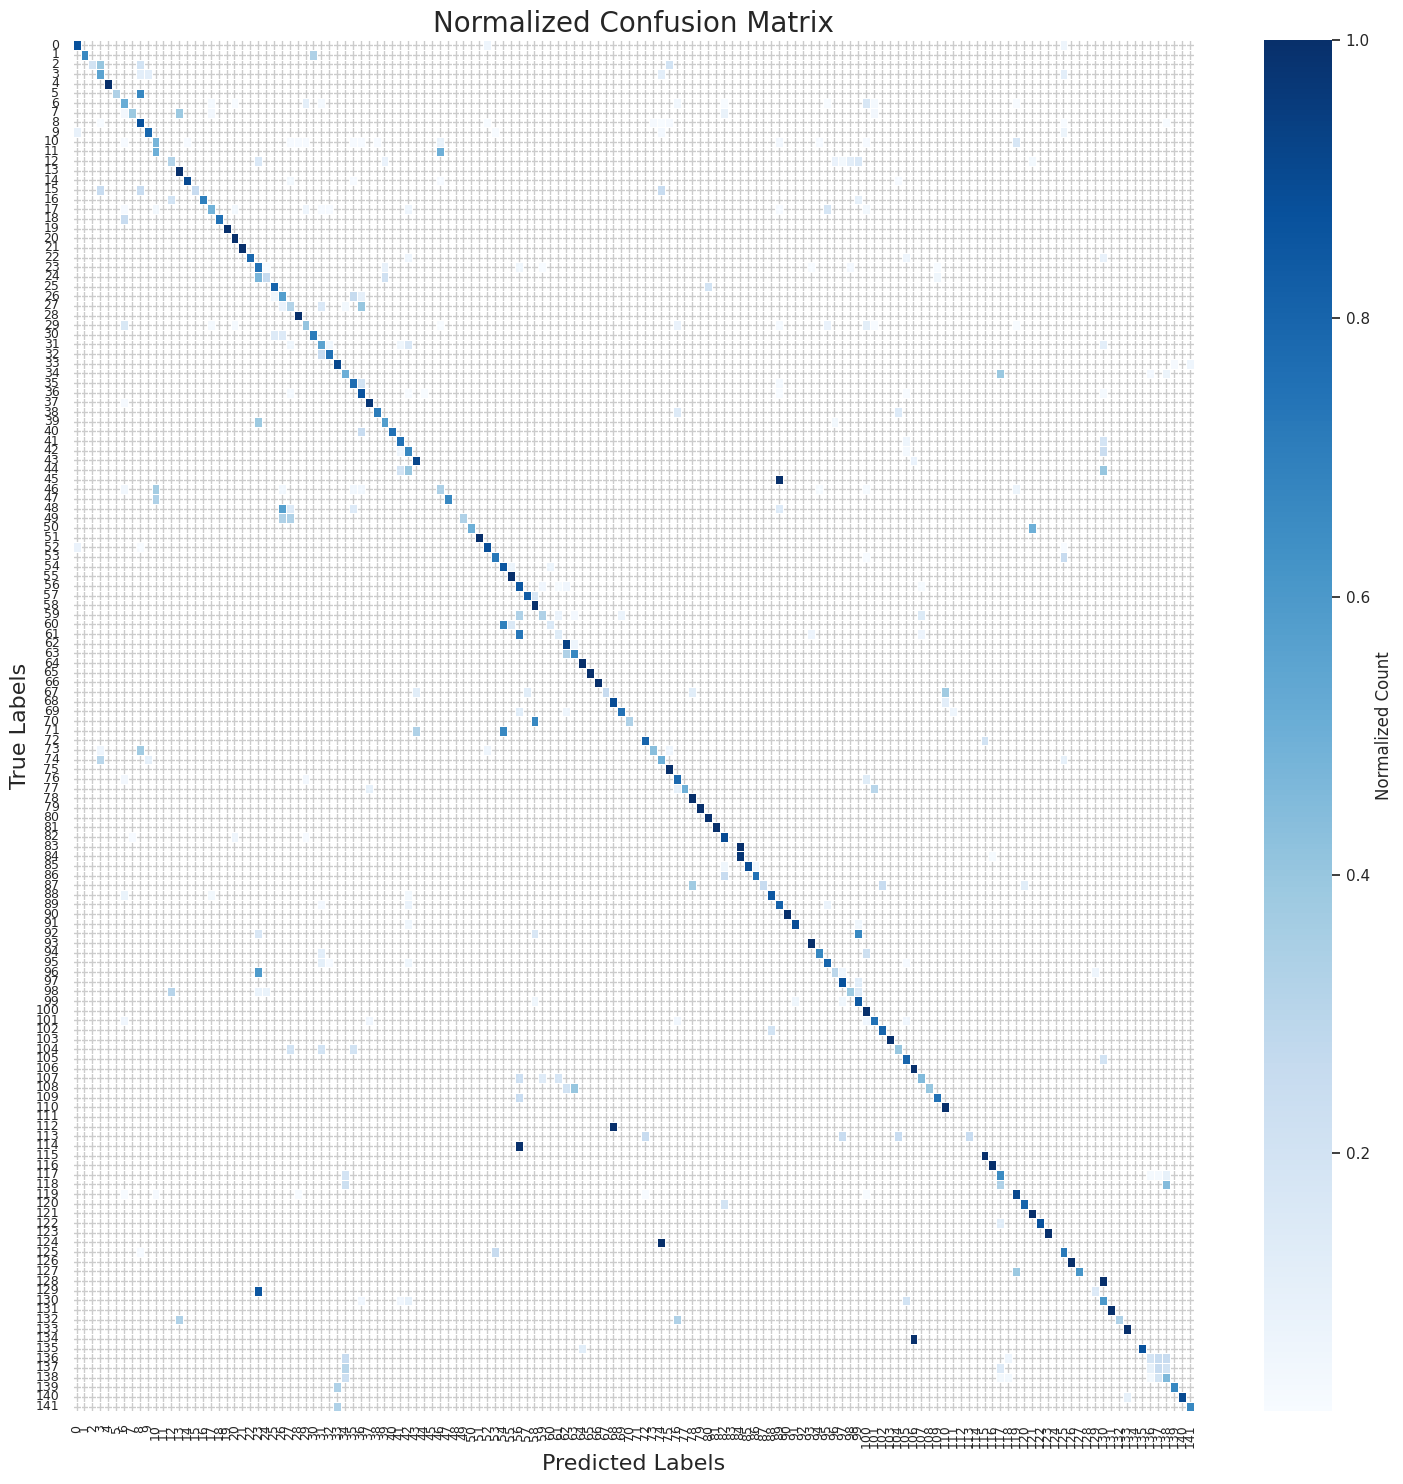

In [36]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(test_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a mask for zero values to color them white
mask = cm_normalized == 0

# Plotting the normalized confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm_normalized, annot=False, cmap='Blues', xticklabels=range(142), yticklabels=range(142),
            cbar_kws={'label': 'Normalized Count'}, mask=mask, linewidths=0.5, linecolor='white')
plt.xlabel('Predicted Labels', fontsize=16)
plt.ylabel('True Labels', fontsize=16)
plt.title('Normalized Confusion Matrix', fontsize=20)
plt.xticks(rotation=90, fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.savefig(f'{model_results_folder}/conf_matrix.png')
plt.show()

##### Classification Report

In [59]:
from sklearn.metrics import classification_report

report = classification_report(test_labels, pred_labels, target_names=[f'Class {i}' for i in range(142)])

with open(f'{model_results_folder}/classification_report.txt', 'w') as file:
  file.write(report)

/home/luka/Work/anaconda3/envs/dataenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luka/Work/anaconda3/envs/dataenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luka/Work/anaconda3/envs/dataenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

##### Salience Map

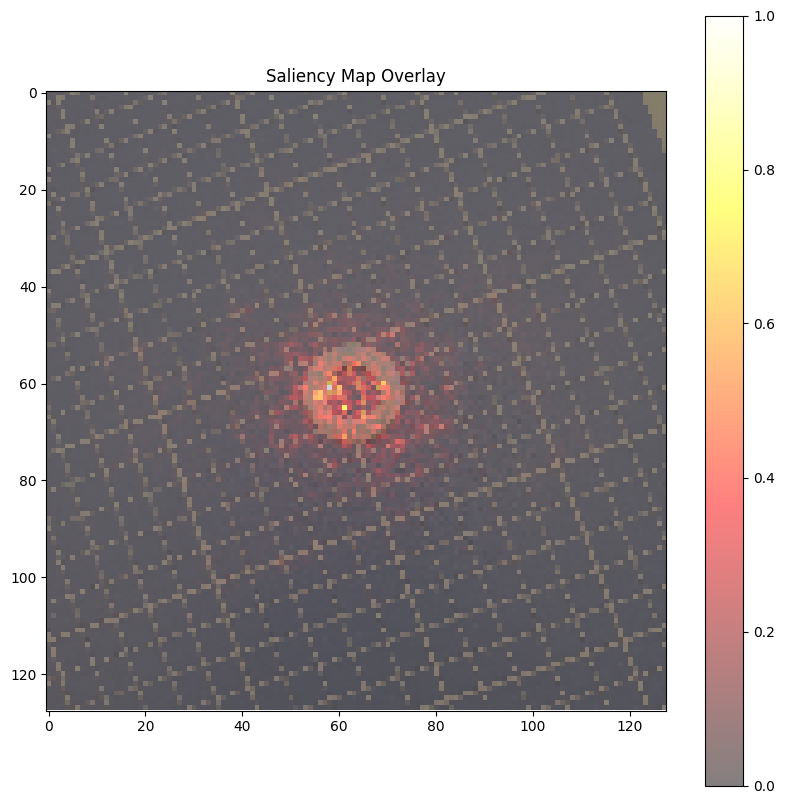

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

index = random.randint(0, len(test_images) - 1)
test_image = test_images[index].astype(np.short)

def get_saliency_map(model, img):
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = tf.expand_dims(img, axis=0)  # Ensure the image is batched

    with tf.GradientTape() as tape:
        tape.watch(img)
        preds = model(img, training=False)
        top_class = tf.argmax(preds[0])
        top_class_score = preds[:, top_class]

    grads = tape.gradient(top_class_score, img)
    if grads is None:
        raise ValueError("Gradients computation returned None. Check if the model and input are set up correctly.")
    
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]  
    saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency))  

    return saliency.numpy()

# Example usage with a single test image
saliency_map = get_saliency_map(test_model, test_image)

plt.figure(figsize=(10, 10))
plt.imshow(test_image, cmap='gray', alpha=0.5)  
plt.imshow(saliency_map, cmap='hot', alpha=0.5)  
plt.colorbar()
plt.title('Saliency Map Overlay')
plt.show()

##### PCA

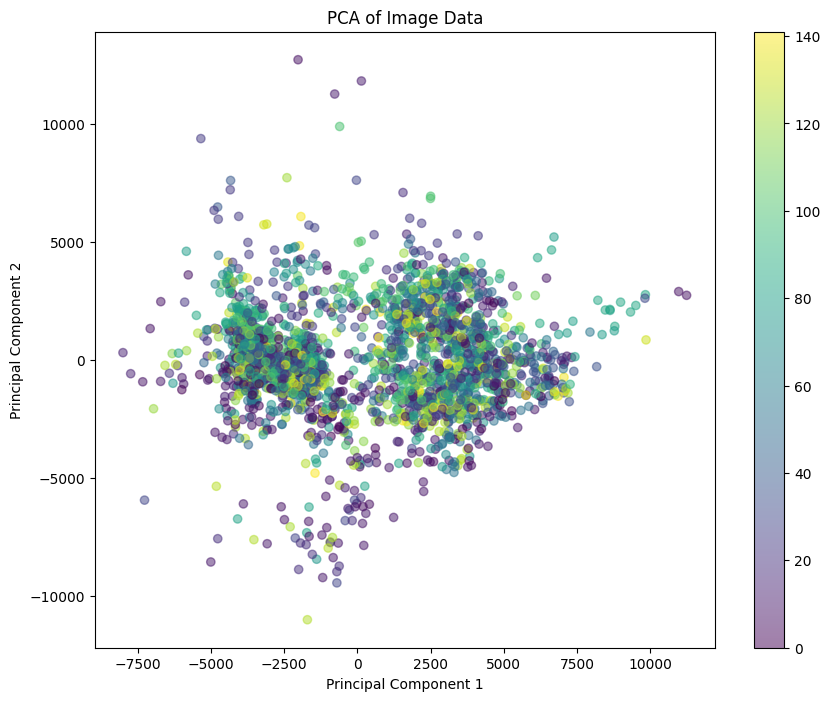

In [102]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Flatten the images to shape (num_samples, height * width * channels)
num_samples, height, width, channels = test_images.shape
flat_images = test_images.reshape(num_samples, -1)

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
pca_result = pca.fit_transform(flat_images)

# Plot the PCA result
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=test_labels, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title('PCA of Image Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

##### t-SNE

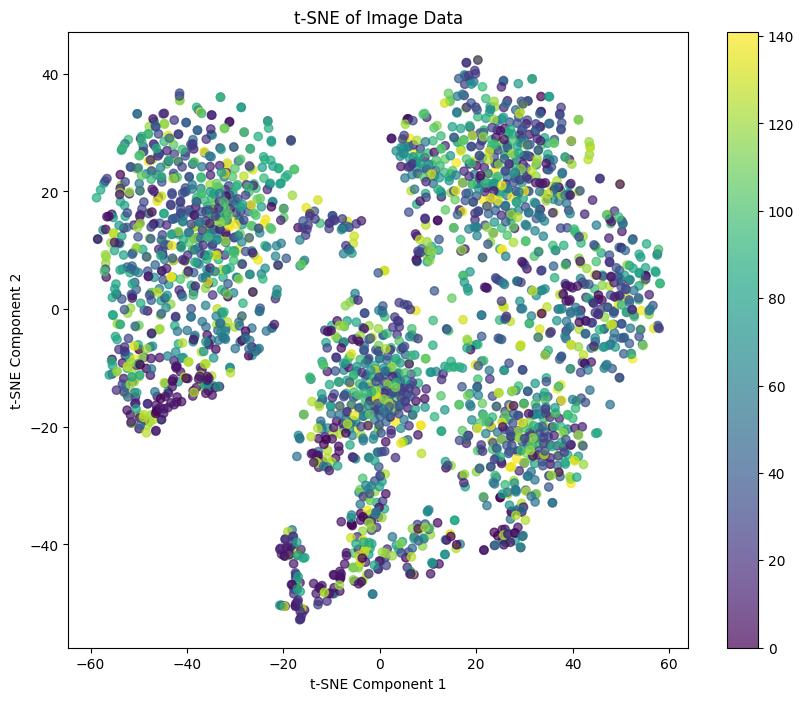

In [103]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Flatten the images to shape (num_samples, height * width * channels)
num_samples, height, width, channels = test_images.shape
flat_images = test_images.reshape(num_samples, -1)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(flat_images)

# Plot the t-SNE result
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=test_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.title('t-SNE of Image Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()